In [54]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import sklearn, pandas as pd
import librosa, librosa.display
import sys
import time
from pathlib import Path
import numpy, urllib
import librosa.feature as lf
from sklearn.metrics import classification_report, confusion_matrix
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [13]:
every_composer = ['albeniz', 'beethoven', 'brahms', 'chopin', 'clementi', 'debussy', 'grieg', 'haydn', 'liszt','mendel', 'mozart', 'rachmaninoff', 'schubert', 'schumman','tchaikovsky']


In [35]:
data_principal = np.load('data_principal_21.npy')

In [15]:
def folder_to_features(folder_name):
    fcl = [lf.spectral_centroid,
    lf.spectral_bandwidth,
    lf.spectral_contrast,
    lf.spectral_rolloff,
    lf.mfcc,
    lf.zero_crossing_rate]
    
    n_mfcc = 12
    audio_time_series_list = []
    song_count = 0
    
    mp3_names =[
        str(p)[len(f'{folder_name}/'):-len('.mp3')] for p in Path().glob(f'{folder_name}/*.mp3')
    ]
    
    for p in Path().glob(f'{folder_name}/*.mp3'):  
        for i in range(10):
            x = librosa.load(p, duration = 5, offset = 5+i*20)[0]
            if x.shape != (0,):
                audio_time_series_list.append(x)
    for song in audio_time_series_list: 
        for f in fcl:
            if f == lf.spectral_centroid:
                feature_i = f(y=song).T
                feature_i = np.hstack((np.mean(feature_i, axis = 0), np.std(feature_i, axis = 0)))
            else:
                current = f(y=song).T
                feature_i = np.hstack((feature_i, np.mean(current, axis = 0), np.std(current, axis = 0)))
        if song_count == 0:
            total_array = feature_i
        else:
            total_array = np.vstack((total_array, feature_i))
        song_count += 1
    label_array = np.full((total_array.shape[0],1), folder_name)
    total_array = np.hstack((label_array, total_array))
    return total_array

In [16]:
def combine_multiple_folder_sets(folder_name_list):
    for folder_data in folder_name_list:
        if folder_data == folder_name_list[0]:
            all_data = folder_to_features(folder_data)
        else:
            all_data = np.vstack((all_data, folder_to_features(folder_data)))
    return all_data

In [24]:
def separate_and_split_features_and_labels(all_data, frac = 0.05):
    labels, features = np.split(all_data,[1], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(features, labels,stratify=labels)
    return X_train.astype(float), X_test.astype(float), y_train, y_test

In [18]:
def try_sgdc(X_train_scaled, X_test_scaled, y_train, y_test):
    model = SGDClassifier(loss='hinge')
    model.fit(X_train_scaled, y_train)
    return model, model.score(X_test_scaled, y_test)

In [19]:
loss_functions = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
def try_sgdc_with_lf(X_train_scaled, X_test_scaled, y_train, y_test, lf):
    model = SGDClassifier(loss=lf, n_iter=20)
    model.fit(X_train_scaled, y_train)
    return model, model.score(X_test_scaled, y_test)

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.38054607508532423


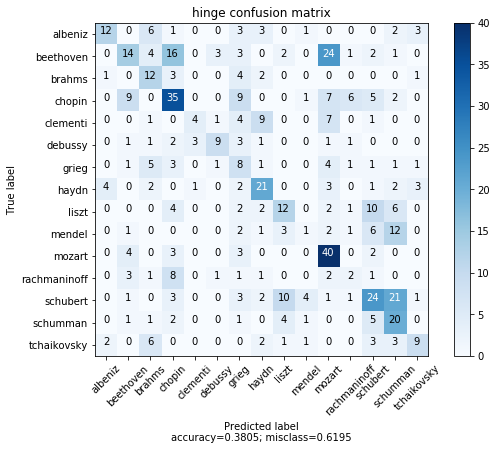

hinge               precision    recall  f1-score   support

     albeniz       0.63      0.39      0.48        31
   beethoven       0.40      0.20      0.27        70
      brahms       0.31      0.52      0.39        23
      chopin       0.44      0.47      0.45        74
    clementi       0.50      0.15      0.23        27
     debussy       0.60      0.41      0.49        22
       grieg       0.17      0.30      0.21        27
       haydn       0.47      0.54      0.50        39
       liszt       0.38      0.31      0.34        39
      mendel       0.11      0.03      0.05        29
      mozart       0.43      0.77      0.55        52
rachmaninoff       0.14      0.10      0.12        20
    schubert       0.39      0.34      0.36        71
    schumman       0.29      0.57      0.38        35
 tchaikovsky       0.50      0.33      0.40        27

   micro avg       0.38      0.38      0.38       586
   macro avg       0.38      0.36      0.35       586
weighted avg       0

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


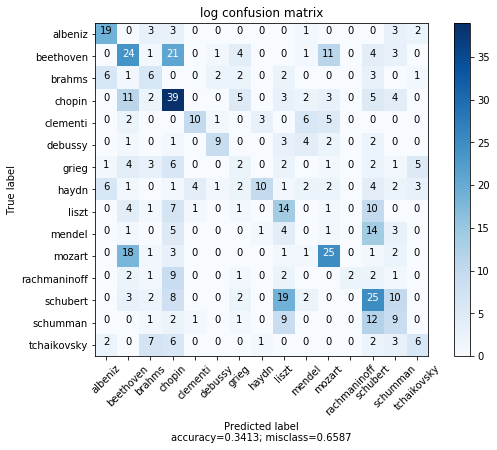

log               precision    recall  f1-score   support

     albeniz       0.56      0.61      0.58        31
   beethoven       0.33      0.34      0.34        70
      brahms       0.21      0.26      0.24        23
      chopin       0.35      0.53      0.42        74
    clementi       0.62      0.37      0.47        27
     debussy       0.64      0.41      0.50        22
       grieg       0.10      0.07      0.09        27
       haydn       0.67      0.26      0.37        39
       liszt       0.23      0.36      0.28        39
      mendel       0.00      0.00      0.00        29
      mozart       0.49      0.48      0.49        52
rachmaninoff       1.00      0.10      0.18        20
    schubert       0.29      0.35      0.32        71
    schumman       0.22      0.26      0.24        35
 tchaikovsky       0.35      0.22      0.27        27

   micro avg       0.34      0.34      0.34       586
   macro avg       0.41      0.31      0.32       586
weighted avg       0.3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


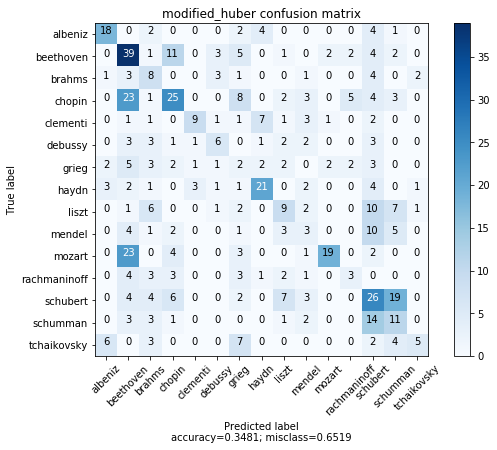

modified_huber               precision    recall  f1-score   support

     albeniz       0.60      0.58      0.59        31
   beethoven       0.34      0.56      0.42        70
      brahms       0.20      0.35      0.25        23
      chopin       0.45      0.34      0.39        74
    clementi       0.64      0.33      0.44        27
     debussy       0.38      0.27      0.32        22
       grieg       0.05      0.07      0.06        27
       haydn       0.58      0.54      0.56        39
       liszt       0.30      0.23      0.26        39
      mendel       0.13      0.10      0.12        29
      mozart       0.79      0.37      0.50        52
rachmaninoff       0.25      0.15      0.19        20
    schubert       0.28      0.37      0.32        71
    schumman       0.21      0.31      0.25        35
 tchaikovsky       0.56      0.19      0.28        27

   micro avg       0.35      0.35      0.35       586
   macro avg       0.38      0.32      0.33       586
weighted av

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


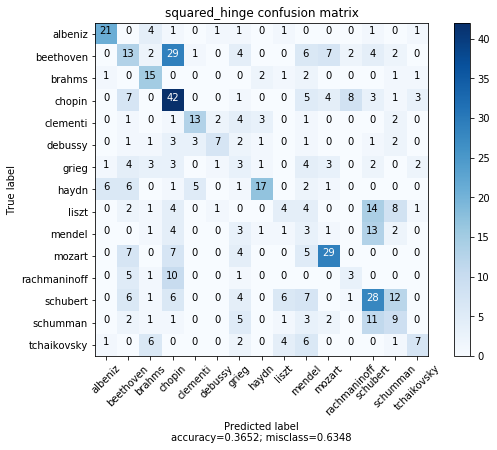

squared_hinge               precision    recall  f1-score   support

     albeniz       0.70      0.68      0.69        31
   beethoven       0.24      0.19      0.21        70
      brahms       0.42      0.65      0.51        23
      chopin       0.38      0.57      0.45        74
    clementi       0.59      0.48      0.53        27
     debussy       0.58      0.32      0.41        22
       grieg       0.09      0.11      0.10        27
       haydn       0.68      0.44      0.53        39
       liszt       0.22      0.10      0.14        39
      mendel       0.06      0.10      0.08        29
      mozart       0.62      0.56      0.59        52
rachmaninoff       0.21      0.15      0.18        20
    schubert       0.36      0.39      0.38        71
    schumman       0.23      0.26      0.24        35
 tchaikovsky       0.47      0.26      0.33        27

   micro avg       0.37      0.37      0.37       586
   macro avg       0.39      0.35      0.36       586
weighted avg

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


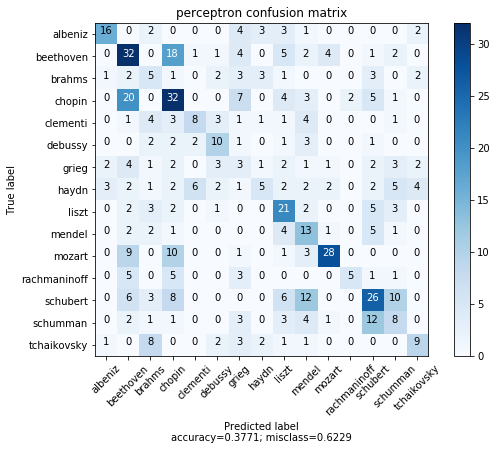

perceptron               precision    recall  f1-score   support

     albeniz       0.70      0.52      0.59        31
   beethoven       0.37      0.46      0.41        70
      brahms       0.16      0.22      0.18        23
      chopin       0.37      0.43      0.40        74
    clementi       0.47      0.30      0.36        27
     debussy       0.42      0.45      0.43        22
       grieg       0.09      0.11      0.10        27
       haydn       0.33      0.13      0.19        39
       liszt       0.38      0.54      0.45        39
      mendel       0.25      0.45      0.33        29
      mozart       0.76      0.54      0.63        52
rachmaninoff       0.71      0.25      0.37        20
    schubert       0.41      0.37      0.39        71
    schumman       0.23      0.23      0.23        35
 tchaikovsky       0.47      0.33      0.39        27

   micro avg       0.38      0.38      0.38       586
   macro avg       0.41      0.35      0.36       586
weighted avg   

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


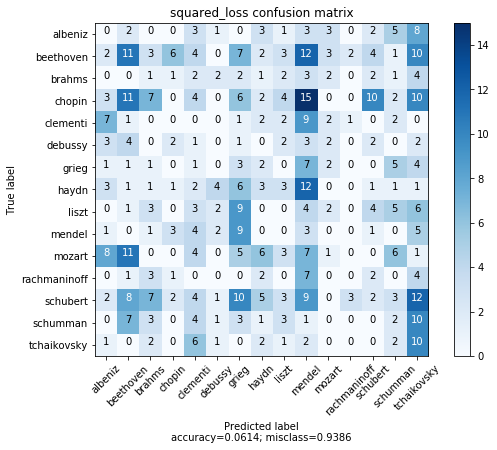

squared_loss               precision    recall  f1-score   support

     albeniz       0.00      0.00      0.00        31
   beethoven       0.19      0.16      0.17        70
      brahms       0.03      0.04      0.04        23
      chopin       0.00      0.00      0.00        74
    clementi       0.00      0.00      0.00        27
     debussy       0.00      0.00      0.00        22
       grieg       0.05      0.11      0.07        27
       haydn       0.10      0.08      0.09        39
       liszt       0.00      0.00      0.00        39
      mendel       0.03      0.10      0.05        29
      mozart       0.06      0.02      0.03        52
rachmaninoff       0.00      0.00      0.00        20
    schubert       0.07      0.03      0.04        71
    schumman       0.06      0.06      0.06        35
 tchaikovsky       0.11      0.37      0.18        27

   micro avg       0.06      0.06      0.06       586
   macro avg       0.05      0.06      0.05       586
weighted avg 

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


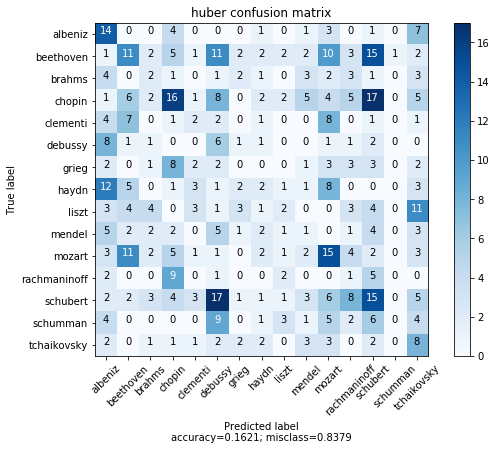

huber               precision    recall  f1-score   support

     albeniz       0.21      0.45      0.29        31
   beethoven       0.22      0.16      0.18        70
      brahms       0.10      0.09      0.09        23
      chopin       0.28      0.22      0.24        74
    clementi       0.12      0.07      0.09        27
     debussy       0.09      0.27      0.13        22
       grieg       0.00      0.00      0.00        27
       haydn       0.11      0.05      0.07        39
       liszt       0.13      0.05      0.07        39
      mendel       0.04      0.03      0.04        29
      mozart       0.22      0.29      0.25        52
rachmaninoff       0.03      0.05      0.04        20
    schubert       0.19      0.21      0.20        71
    schumman       0.00      0.00      0.00        35
 tchaikovsky       0.14      0.30      0.19        27

   micro avg       0.16      0.16      0.16       586
   macro avg       0.13      0.15      0.13       586
weighted avg       0

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


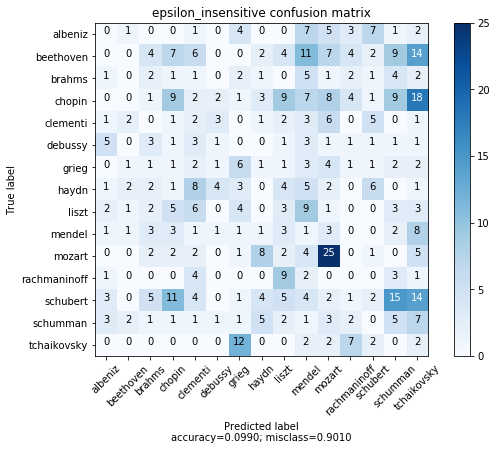

epsilon_insensitive               precision    recall  f1-score   support

     albeniz       0.00      0.00      0.00        31
   beethoven       0.00      0.00      0.00        70
      brahms       0.08      0.09      0.08        23
      chopin       0.21      0.12      0.15        74
    clementi       0.05      0.07      0.06        27
     debussy       0.08      0.05      0.06        22
       grieg       0.17      0.22      0.19        27
       haydn       0.00      0.00      0.00        39
       liszt       0.07      0.08      0.07        39
      mendel       0.01      0.03      0.02        29
      mozart       0.36      0.48      0.41        52
rachmaninoff       0.00      0.00      0.00        20
    schubert       0.07      0.03      0.04        71
    schumman       0.09      0.14      0.11        35
 tchaikovsky       0.02      0.07      0.04        27

   micro avg       0.10      0.10      0.10       586
   macro avg       0.08      0.09      0.08       586
weight

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


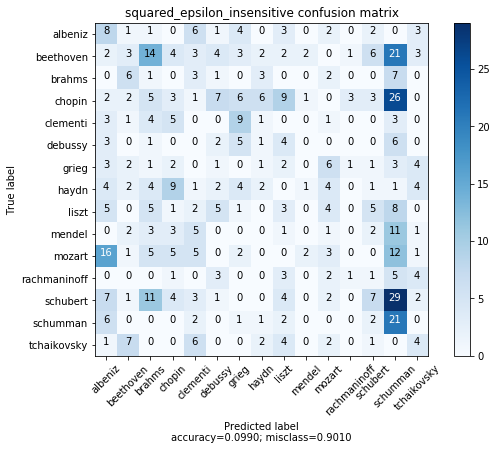

squared_epsilon_insensitive               precision    recall  f1-score   support

     albeniz       0.13      0.26      0.18        31
   beethoven       0.11      0.04      0.06        70
      brahms       0.02      0.04      0.03        23
      chopin       0.08      0.04      0.05        74
    clementi       0.00      0.00      0.00        27
     debussy       0.07      0.09      0.08        22
       grieg       0.00      0.00      0.00        27
       haydn       0.11      0.05      0.07        39
       liszt       0.08      0.08      0.08        39
      mendel       0.00      0.00      0.00        29
      mozart       0.10      0.06      0.07        52
rachmaninoff       0.17      0.05      0.08        20
    schubert       0.23      0.10      0.14        71
    schumman       0.14      0.60      0.22        35
 tchaikovsky       0.15      0.15      0.15        27

   micro avg       0.10      0.10      0.10       586
   macro avg       0.09      0.10      0.08       58

In [55]:
for loss_function in loss_functions:
    #print(loss_function)
    #all_data = np.load('all_composers.npy')
    X_train_scaled_real, X_test_scaled_real, y_train_real, y_test_real = separate_and_split_features_and_labels(data_principal)
    model_real, score_real = try_sgdc_with_lf(X_train_scaled_real, X_test_scaled_real, np.ravel(y_train_real), np.ravel(y_test_real), loss_function)
    print(score_real)
    cm = confusion_matrix(y_test_real, model_real.predict(X_test_scaled_real))
    plot_confusion_matrix(cm,every_composer,normalize=False,title=f'{loss_function} confusion matrix')
    print(loss_function, classification_report(np.ravel(y_test_real), model_real.predict(X_test_scaled_real)))

In [56]:
# all_data = np.load('all_composers.npy')
X_train_scaled_real, X_test_scaled_real, y_train_real, y_test_real = separate_and_split_features_and_labels(data_principal)
# model_small, score_small = try_sgdc(X_train_scaled_small, X_test_scaled_small, y_train_small, y_test_small)
# score_small
# print(classification_report(y_test_small, model_small.predict(X_test_scaled_small)))
# confusion_matrix(y_test_small, model_small.predict(X_test_scaled_small))

model = sklearn.svm.SVC()
model.fit(X_train_scaled_real, y_train_real)
print(model.score(X_test_scaled_real, y_test_real))
print(classification_report(y_test_real, model.predict(X_test_scaled_real)))
print(confusion_matrix(y_test_real, model.predict(X_test_scaled_real)))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5341296928327645
              precision    recall  f1-score   support

     albeniz       0.70      0.68      0.69        31
   beethoven       0.41      0.64      0.50        70
      brahms       0.50      0.43      0.47        23
      chopin       0.54      0.66      0.59        74
    clementi       0.65      0.56      0.60        27
     debussy       0.65      0.50      0.56        22
       grieg       0.45      0.19      0.26        27
       haydn       0.56      0.64      0.60        39
       liszt       0.60      0.54      0.57        39
      mendel       0.33      0.03      0.06        29
      mozart       0.77      0.69      0.73        52
rachmaninoff       1.00      0.10      0.18        20
    schubert       0.46      0.72      0.56        71
    schumman       0.40      0.23      0.29        35
 tchaikovsky       0.62      0.48      0.54        27

   micro avg       0.53      0.53      0.53       586
   macro avg       0.58      0.47      0.48       586
weighte

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was

Max Accuracy is 0.464 on test dataset with 5 neighbors.

Training Score: 0.658
Test score: 0.464


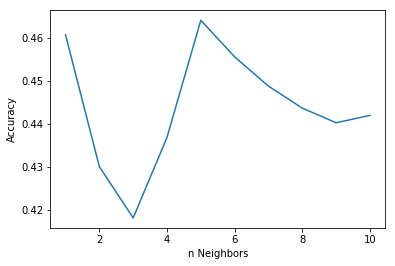

In [57]:
from sklearn.neighbors import KNeighborsClassifier

results_knn=[]
for i in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled_real,y_train_real)
    results_knn.append(knn.score(X_test_scaled_real,y_test_real))
    
max_accuracy_knn=max(results_knn)
best_k=1+results_knn.index(max(results_knn))
print("Max Accuracy is {:.3f} on test dataset with {} neighbors.\n".format(max_accuracy_knn,best_k))

plt.plot(numpy.arange(1,11),results_knn)
plt.xlabel("n Neighbors")
plt.ylabel("Accuracy")


knn=KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled_real,y_train_real)
print("Training Score: {:.3f}".format(knn.score(X_train_scaled_real,y_train_real)))
print("Test score: {:.3f}".format(knn.score(X_test_scaled_real,y_test_real)))  

Max Accuracy is 0.451 on test dataset with 26 estimators.

Training Score: 0.836
Test score: 0.387
[[16  0  2  1  0  0  1  2  0  1  0  0  0  0  7]
 [ 0 27  0 17  1  0  1  2  3  4  9  7  9  2  0]
 [ 2  1  4  0  0  1  1  0  0  0  0  0  0  0  3]
 [ 0 26  3 40  0  5  8  0  2  4  4 11  6  5  0]
 [ 0  0  1  0 13  5  0  6  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  2  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  1  0  0  0  0  0  0  0  2]
 [ 7  0  2  1  8  1  5 21  1  1  0  0  0  0  1]
 [ 0  0  0  4  1  0  1  1  9  0  0  1  3  2  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 11  0  3  3  3  1  0  2  1 37  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  7  4  1  5  1  6 22 16  1  1 44 24  2]
 [ 0  0  0  2  0  0  0  0  0  2  0  0  6  2  0]
 [ 4  0  4  1  0  0  6  1  0  0  0  0  1  0 11]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


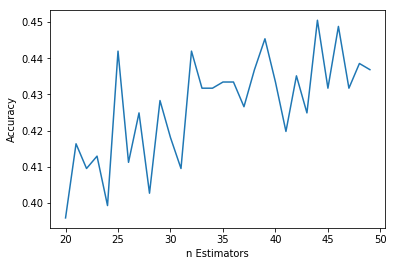

In [58]:
from sklearn.ensemble import RandomForestClassifier
results_forest=[]
for i in range(20,50):
    forest=RandomForestClassifier(n_estimators=i, max_depth=8, max_features = 'sqrt')
    forest.fit(X_train_scaled_real,np.ravel(y_train_real))
    results_forest.append(forest.score(X_test_scaled_real,np.ravel(y_test_real)))
    
max_accuracy_forest=max(results_forest)
best_n_est=2+results_forest.index(max(results_forest))
print("Max Accuracy is {:.3f} on test dataset with {} estimators.\n".format(max_accuracy_forest,best_n_est))

plt.plot(numpy.arange(20,50),results_forest)
plt.xlabel("n Estimators")
plt.ylabel("Accuracy")


forest=RandomForestClassifier(n_estimators=best_n_est, max_depth=8, max_features = 'sqrt')
forest.fit(X_train_scaled_real,y_train_real)
print("Training Score: {:.3f}".format(forest.score(X_train_scaled_real,y_train_real)))
print("Test score: {:.3f}".format(forest.score(X_test_scaled_real,np.ravel(y_test_real))))

print(confusion_matrix(forest.predict(X_test_scaled_real),np.ravel(y_test_real)))

In [59]:
X_train_scaled, X_test_scaled, y_train, y_test = separate_and_split_features_and_labels(data_principal)
clf_test = xgb.XGBClassifier(booster = 'dart', reg_lambda = 5, reg_alpha= 0.5,learning_rate =0.1,max_depth= 6, min_child_weight=5,n_estimators=100,subsample=0.8, n_jobs=-1)
clf_test.fit(X_train_scaled, np.ravel(y_train))
training_preds = clf_test.predict(X_train_scaled)
val_preds = clf_test.predict(X_test_scaled)

training_accuracy = accuracy_score(np.ravel(y_train), training_preds)
val_accuracy = accuracy_score(np.ravel(y_test), val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 98.06%
Validation accuracy: 48.12%
